<a href="https://colab.research.google.com/github/JgibsonAB/Wine_capstone/blob/main/Wine_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import string
import collections

import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk import FreqDist

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn import metrics
from pprint import pprint

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

nltk.download('stopwords')
nltk.download('punkt')

from joblib import dump, load

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
import numpy as np
nltk.download('wordnet')
from gensim.models.phrases import Phrases, Phraser

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [83]:
from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter, OrderedDict
from sklearn.neighbors import NearestNeighbors

In [4]:
##only needed if using google colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
wine_data = pd.read_csv('gdrive/My Drive/winemag-data-130k-v2.csv')

In [6]:
wine_data.describe()

,Unnamed: 0,points,price
count,129971.000000,129971.000000,120975.000000
mean,64985.000000,88.447138,35.363389
std,37519.540256,3.039730,41.022218
min,0.000000,80.000000,4.000000
25%,32492.500000,86.000000,17.000000
50%,64985.000000,88.000000,25.000000
75%,97477.500000,91.000000,42.000000
max,129970.000000,100.000000,3300.000000


In [7]:
wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             129971 non-null  int64  
 1   country                129908 non-null  object 
 2   description            129971 non-null  object 
 3   designation            92506 non-null   object 
 4   points                 129971 non-null  int64  
 5   price                  120975 non-null  float64
 6   province               129908 non-null  object 
 7   region_1               108724 non-null  object 
 8   region_2               50511 non-null   object 
 9   taster_name            103727 non-null  object 
 10  taster_twitter_handle  98758 non-null   object 
 11  title                  129971 non-null  object 
 12  variety                129970 non-null  object 
 13  winery                 129971 non-null  object 
dtypes: float64(1), int64(2), object(11)


In [8]:
wine_data = wine_data.drop(columns=['Unnamed: 0','taster_twitter_handle'])

In [9]:
# Create new column with vintage year

# Define function to get vintage year
def get_vintage(input_df):
    vintage_col = []
    #year = int()
    for title in input_df['title'].str.split():
        year = []
        for word in title:
            if word.isdigit() and (1929 < int(word) < 2020):
                year.append(int(word))
        if len(year) > 0:
            vintage_col.append(max(year))
        else:
            vintage_col.append(None)   
    return vintage_col

# Add column with vintage year to wine dataFrame
wine_data['vintage'] = get_vintage(wine_data)
wine_data.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,title,variety,winery,vintage
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,2013.0
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011.0
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013.0
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013.0
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012.0


In [10]:
# Exclude missing values in: ['price', 'country', 'province', 'variety', 'vintage']
cols_to_drop = ['price', 'country', 'province', 'variety', 'vintage']
wine_df = wine_data.dropna(subset=cols_to_drop).reset_index(drop=True)

In [11]:
# Drop duplicated wine titles
wine_df = wine_df.drop_duplicates(subset='title', keep='first').reset_index(drop=True)

print(f'Total number of reviews after excluding duplicated wines: {wine_df.shape[0]}')

Total number of reviews after excluding duplicated wines: 107342


In [12]:
# Convert vintage year to integer
wine_df['vintage'] = wine_df['vintage'].astype(int)
wine_df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,title,variety,winery,vintage
0,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011
1,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013
2,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013
3,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012
4,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011


In [13]:
# Check wine varieties names
pd.set_option("display.max_rows", None)
wine_df['variety'].value_counts(normalize=True).to_frame()

,variety
Pinot Noir,0.108485
Chardonnay,0.092815
Cabernet Sauvignon,0.081273
Red Blend,0.070578
Bordeaux-style Red Blend,0.045546
Riesling,0.042248
Sauvignon Blanc,0.040636
Syrah,0.035112
Rosé,0.027128
Merlot,0.026383


In [14]:
# Some wines have different spellings/by country spellings (and mispellings)

# Build a dictionaty to consolidate varieties
variety_dict = {'Pinot Nero': 'Pinot Noir',
                'Pinot Gris': 'Pinot Grigio', 
                'Pinot Grigio/Gris': 'Pinot Grigio',
                'Pinot Bianco': 'Pinot Blanc',
                'Shiraz': 'Syrah',
                'Garnacha, Grenache': 'Grenache', 
                'Garnacha': 'Grenache',
                'Garnacha Blanca': 'Grenache Blanc',
                'Alvarinho': 'Albariño',
                'Rosado': 'Rosé', 
                'Rosato': 'Rosé',
                'Monastrell': 'Mourvèdre',
                'Moscato': 'Muscat'
                }

# function to consolidate variety names
def get_consol_var(variety):
    if variety in variety_dict:
        return variety_dict[variety]
    else:
        return variety

# Consolidate 
wine_df['variety'] = wine_df['variety'].apply(get_consol_var)
wine_df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,title,variety,winery,vintage
0,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011
1,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Grigio,Rainstorm,2013
2,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013
3,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012
4,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011


**Now that we have cleaned things up. Lets dig into the EDA**

We now have a good idea about the information the dataset contains. We know that each wine has a description field, made out of text (This will be heavily used later on). We will use this desrciption to create a "binary fingerprint" for each description in the set, then cluster wines using these fingerprints. 
Creating these fingerprints can be separated into 2 steps:
1) split the sentences describing each wine into a list of words and removing unnecessary noise/stop words.
2) vectorize these lists (convert list of words into binary, vectors of 0's and 1's) so that they can then be used as input for the machine elarning algorithm (clustering)

In [15]:
def plot_frequency_of_occurence(df, col):
    
    s2=df[col]
    prob = s2.value_counts(normalize=True)
    threshold = 0.01
    mask = prob > threshold
    tail_prob = prob.loc[~mask].sum()
    prob = prob.loc[mask]
    prob['other'] = tail_prob
    prob = prob.to_frame()
    prob = prob.rename(columns={col: "frequency"}) 

    plt.figure(figsize=(10, 10))
    plt.title('Showing % of occurence in '+col)
    sns.barplot(y=prob.index, x='frequency', data = prob, palette="Reds_d");
    return

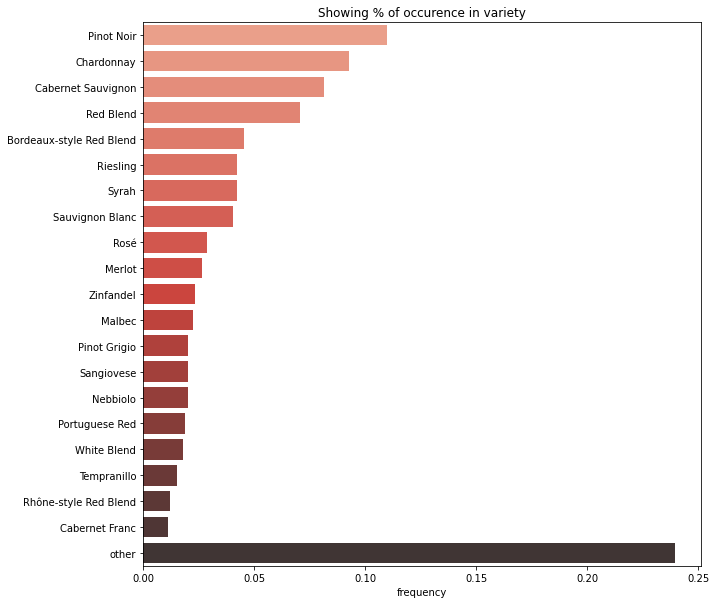

In [16]:
# Plot what kind of wines are found in the set
# expects 1 word per row in selected column

plot_frequency_of_occurence(wine_df, 'variety')

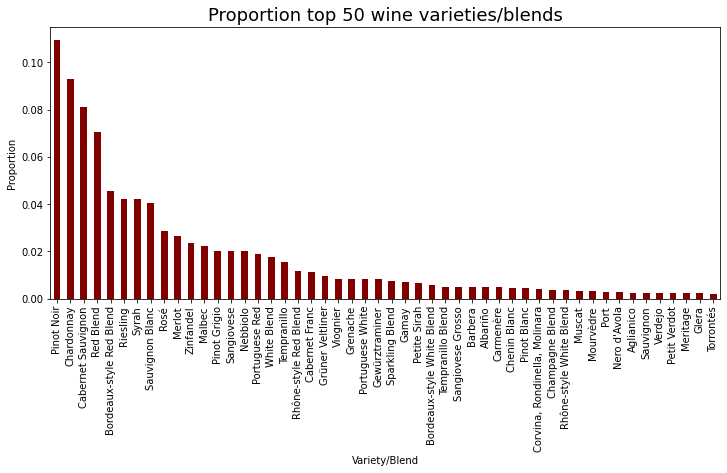

In [17]:
# a more in depth look at the break down
wine_df['variety'].value_counts(normalize=True)[0:50].plot(kind='bar', 
                                                           color='maroon',
                                                           figsize=(12, 5),
                                                          )
plt.title('Proportion top 50 wine varieties/blends', size=18)
plt.xlabel('Variety/Blend')
plt.ylabel('Proportion')
plt.show()

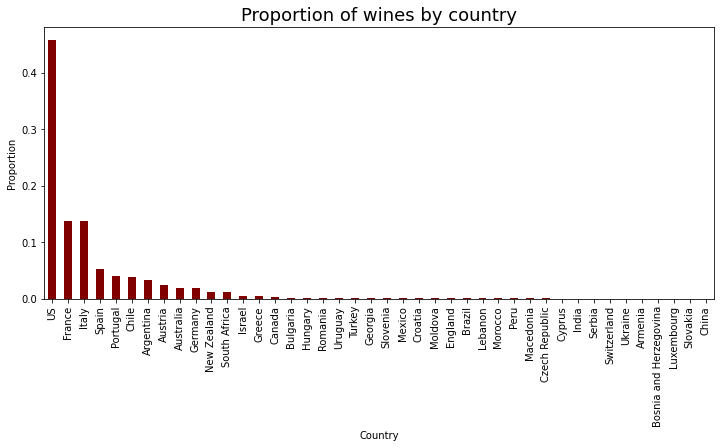

In [18]:
# Plot proportion of wines by country
wine_df['country'].value_counts(normalize=True).plot(kind='bar', 
                                       color='maroon',
                                       figsize=(12, 5)
                                      )
plt.title('Proportion of wines by country', size=18)
plt.xlabel('Country')
plt.ylabel('Proportion')
plt.show()

In [19]:
def plot_freq_words(df, col, how_many = 10, title = None, size = (10,10)):
    
    l = list(df[col])
    flat_list = [item for sublist in l for item in sublist]
    freq = FreqDist(flat_list)

    most_frequent_words = pd.DataFrame(freq.most_common(how_many), columns =['word', 'freq'])
    
    sns.set(style="whitegrid")
    plt.figure(figsize=size)
    plt.title(title)
    sns.barplot(x="freq", y="word", data=most_frequent_words, palette="Reds_d");

    return most_frequent_words

In [20]:
most_expensive = wine_df.loc[[wine_df['price'].idxmax()]]
most_expensive

,country,description,designation,points,price,province,region_1,region_2,taster_name,title,variety,winery,vintage
68271,France,This ripe wine shows plenty of blackberry frui...,NaN,88,3300.0,Bordeaux,Médoc,NaN,Roger Voss,Château les Ormes Sorbet 2013 Médoc,Bordeaux-style Red Blend,Château les Ormes Sorbet,2013


In [21]:
least_expensive = wine_df.loc[[wine_df['price'].idxmin()]]
least_expensive

,country,description,designation,points,price,province,region_1,region_2,taster_name,title,variety,winery,vintage
1810,Spain,Berry and cherry aromas are surprisingly sturd...,Flirty Bird,85,4.0,Central Spain,Vino de la Tierra de Castilla,NaN,Michael Schachner,Felix Solis 2013 Flirty Bird Syrah (Vino de la...,Syrah,Felix Solis,2013


In [22]:
#wines with perfect 100 point scores
perfect_wines =wine_df[wine_df['points']==100]
perfect_wines[['country', 'price', 'province', 'variety', 'winery']].sort_values(by=['price'], ascending=False)

,country,price,province,variety,winery
93315,France,1500.0,Bordeaux,Bordeaux-style Red Blend,Château Lafite Rothschild
93317,France,1500.0,Bordeaux,Bordeaux-style Red Blend,Château Cheval Blanc
95793,Portugal,650.0,Port,Port,Quinta do Noval
75963,France,617.0,Champagne,Chardonnay,Salon
39804,Italy,550.0,Tuscany,Sangiovese,Biondi Santi
34338,Italy,460.0,Tuscany,Merlot,Tenuta dell'Ornellaia
36819,Portugal,450.0,Douro,Portuguese Red,Casa Ferreirinha
98164,US,450.0,California,Bordeaux-style Red Blend,Verité
93318,France,359.0,Bordeaux,Bordeaux-style Red Blend,Château Léoville Las Cases
93316,Italy,270.0,Tuscany,Sangiovese Grosso,Casanova di Neri


In [23]:
## the previous set represented a perfect score. This set only includeds wine with a minimum of 80 points. This represents the "worst"
worst_wines =wine_df[wine_df['points']==80] 
worst_wines[['country', 'price', 'province', 'variety', 'winery']].sort_values(by=['price'], ascending=False)

,country,price,province,variety,winery
87321,US,69.0,California,Zinfandel,Grgich Hills
25152,US,55.0,California,Red Blend,Millésimé
56048,US,45.0,California,Red Blend,Millésimé
90256,US,44.0,California,Zinfandel,Opolo
84575,US,42.0,New York,Cabernet Franc,Catharine Valley
71078,US,40.0,California,Red Blend,Arrowhead Mountain
97463,US,40.0,California,Bordeaux-style Red Blend,Vindemia
67270,US,40.0,California,Red Blend,Spann Vineyards
94962,US,40.0,California,Cabernet Franc,Watts
91597,Spain,40.0,Northern Spain,Tempranillo,Vivencias


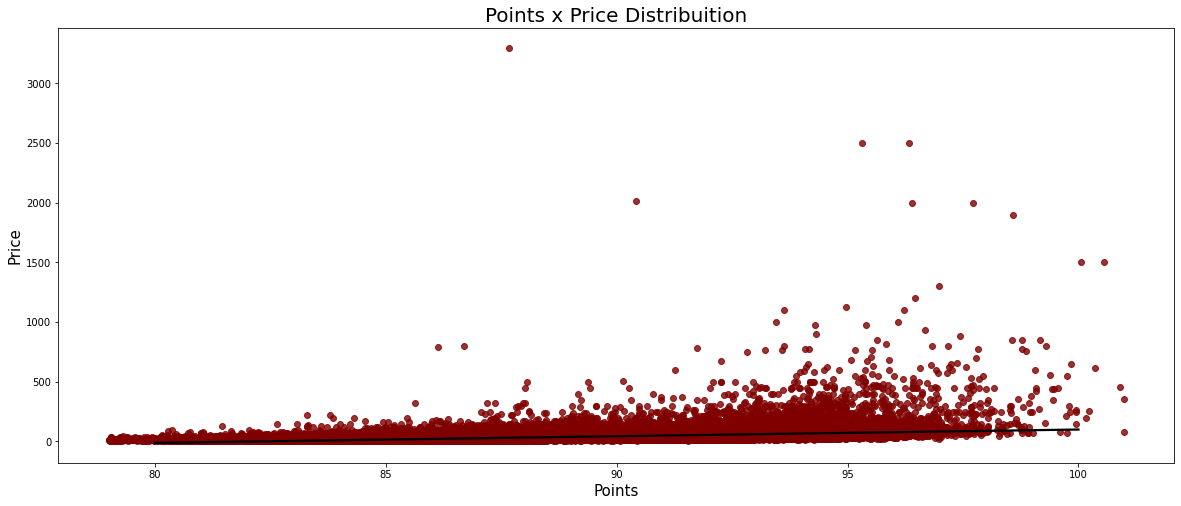

In [24]:
## Correlation between price and point rating. There's an obivous relation. 
#But also shows some hidden gems at lower price points.
plt.figure(figsize=(20,8))

g = sns.regplot(x='points', y='price', 
                data=wine_data, line_kws={'color':'black'},
                x_jitter=True, fit_reg=True, color = 'maroon')
g.set_title("Points x Price Distribuition", fontsize=20)
g.set_xlabel("Points", fontsize= 15)
g.set_ylabel("Price", fontsize= 15)

plt.show()

In [25]:
# Lets take a peak at what they are
top_95 = wine_data[wine_data['points']>=95]
top_95_cheap = top_95[top_95['price']<=30]
top_95_cheap.groupby(['title']).aggregate(np.mean).reset_index().sort_values('price', ascending=True)

,title,points,price,vintage
2,Alain Brumont 2010 Château Bouscassé Red (Madi...,95.0,20.0,2010.0
35,Rulo 2007 Syrah (Columbia Valley (WA)),96.0,20.0,2007.0
33,Poet's Leap 2009 Riesling (Columbia Valley (WA)),95.0,20.0,2009.0
18,Dunham 2010 Lewis Estate Vineyard Riesling (Co...,95.0,20.0,2010.0
25,Januik 2012 Bacchus Vineyard Riesling (Columbi...,95.0,20.0,2012.0
19,EOS 2006 Tears of Dew Late Harvest Moscato (Pa...,95.0,22.0,2006.0
36,Sineann 2013 Riesling (Oregon),95.0,24.0,2013.0
29,La Clarine Farm 2011 Cedarville Mourvèdre (Sie...,95.0,24.0,2011.0
0,Abbazia di Novacella 2015 Praepositus Kerner (...,95.0,25.0,2015.0
38,Southard 2010 Whipping Boy Cabernet Sauvignon ...,95.0,25.0,2010.0


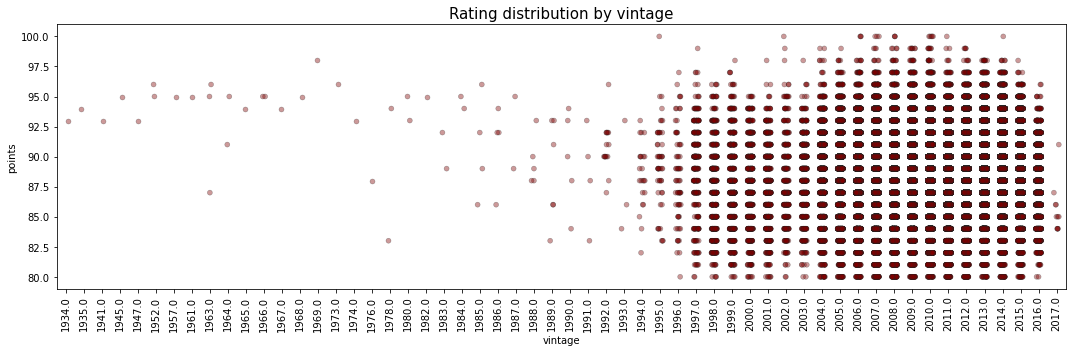

In [26]:
# Wine ratings by vintage (vintage can likely be a feature that is dropped)
plt.figure(figsize=(15, 5))
sns.stripplot(y='points', 
            x='vintage',
            data=wine_data,
            color='maroon',
            jitter=0.15,
            linewidth=0.5,
            alpha=0.4
           )
plt.title('Rating distribution by vintage', fontsize=15)
plt.xticks(rotation='vertical')
plt.tight_layout()

In [27]:
# parse the description sentences for each wine into a list of words
wine_data['parsed_descr'] = wine_data['description'].apply(parse_decription)
# check the most frequent words
m = plot_freq_words(wine_data, 'parsed_descr', how_many = 50)

NameError: ignored

**Now we will build a basic nlp to recommend 5 wines. The actual model will be built in a seperate notebook. And will use Bert and Huggyface. This one will more or less be tf-idf to get and idea of what is worth using.**

In [28]:
# For this original I will use the top 9 grapes for red and white,
# In the actual model I will include blends. This should give an idea of word importance

red_grape = [
    'Pinot Noir',
    'Merlot',
    'Sangiovese',
    'Nebbiolo',
    'Cabernet Sauvignon',
    'Syrah',
    'Tempranillo',
    'Malbec',
    'Grenache'
]

white_grape = [
    'Chardonnay',
    'Pinot Grigio',
    'Riesling',
    'Sauvignon Blanc',
    'Chenin Blanc',
    'Muscat',
    'Gewürztraminer',
    'Sémillon',
    'Viognier'
]

In [29]:
# Create new dataframe with varietals only
wine_grape = wine_data[wine_data['variety'].isin(red_grape+white_grape)].reset_index(drop=True)
print(f'Total number of varietal wines: {wine_grape.shape[0]}')
wine_grape.head(5)

Total number of varietal wines: 66439


,country,description,designation,points,price,province,region_1,region_2,taster_name,title,variety,winery,vintage
0,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013.0
1,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012.0
2,France,This dry and restrained wine offers spice in p...,NaN,87,24.0,Alsace,Alsace,NaN,Roger Voss,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach,2012.0
3,Germany,Savory dried thyme notes accent sunnier flavor...,Shine,87,12.0,Rheinhessen,NaN,NaN,Anna Lee C. Iijima,Heinz Eifel 2013 Shine Gewürztraminer (Rheinhe...,Gewürztraminer,Heinz Eifel,2013.0
4,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature,2011.0


In [30]:
# Lets add some stop words that are specific to wine
# Normalize text in each sentence: tokenize, lemmatize, remove punctuation and stopwords

# Set of stopwords
stop_words = set(stopwords.words('english')) 
stopwords_to_add = [
    "drink","taste","like","offer","wine", 
    "flavor","flavors","palate","finish", "aroma",
    "aromas","nose","notes","note","show",
    "pinot","noir","cabernet", "sauvignon","blanc",
    "grigio","chenin","shiraz","barolo","petit", 
    "verdot","franc","grape","style"] + [wine.lower() for wine in white_grape] + [wine.lower() for wine in red_grape]
 
# Update stopwords    
stop_words.update(stopwords_to_add)

# Instantiate lemmatization model
lemma = nltk.wordnet.WordNetLemmatizer()

# Define function to normalize reviews
def get_normalization(input_text, stop_words):
    normalized_words_list = []
    # Tokenize by word
    word_list = word_tokenize(input_text)
    for word in word_list:
        # convert to string
        word = str(word)
        # lower case
        lower_case_word = str.lower(word)
        # lemmatize
        lemma_word = lemma.lemmatize(lower_case_word)
        #punctuation and stopwords
        punctuation_dict = str.maketrans({punct: None for punct in string.punctuation})
        exclude_punctuation = lemma_word.translate(punctuation_dict)
        if len(exclude_punctuation) > 1 and exclude_punctuation not in stop_words:
            normalized_words_list.append(exclude_punctuation)
    return normalized_words_list

# Define function to apply normalization to all reviews
def get_normalized_reviews(reviews, stop_words):
    reviews_list = list(reviews)
    norm_reviews = []
    for review in reviews_list:
        norm_review = get_normalization(review, stop_words)
        norm_reviews.append(norm_review)
    return norm_reviews

In [31]:
# Normalize reviews
normalized_reviews = get_normalized_reviews(wine_grape['description'], stop_words)
normalized_reviews[5]

['dry',
 'spicy',
 'tight',
 'taut',
 'texture',
 'strongly',
 'mineral',
 'character',
 'layered',
 'citrus',
 'well',
 'pepper',
 'food',
 'almost',
 'crisp',
 'aftertaste']

In [32]:
wine_grape['description'].loc[5]

"This is a dry wine, very spicy, with a tight, taut texture and strongly mineral character layered with citrus as well as pepper. It's a food wine with its almost crisp aftertaste."

In [33]:
# creating a function for word pairs to keep sentence structure. aka bigrams
def get_bigrams(reviews_norm, min_count_par=50):
    # Phrases() takes a list of list of words as input
    # Creates relevant phrases from the list of sentences:
    phrases = Phrases(normalized_reviews, min_count=min_count_par)
    # Transform based on detected bigrams:
    bigrams = Phraser(phrases)
    bigrams_sents = []
    for sent in normalized_reviews:
        bigrams_sent = bigrams[sent]
        bigrams_sents.append(bigrams_sent)
    return bigrams_sents

bigrams_sentences = get_bigrams(normalized_reviews, 20)
bigrams_words = [word for sub_sent in bigrams_sentences for word in sub_sent]
bigrams_words[0:50]

['pineapple',
 'rind',
 'lemon_pith',
 'orange_blossom',
 'start',
 'bit',
 'opulent',
 'honeydrizzled',
 'guava',
 'mango',
 'giving',
 'way',
 'slightly',
 'astringent',
 'semidry',
 'much',
 'regular_bottling',
 '2012',
 'come_across',
 'rather',
 'rough',
 'tannic',
 'rustic',
 'earthy',
 'herbal',
 'characteristic',
 'nonetheless',
 'think',
 'pleasantly',
 'unfussy',
 'country',
 'good',
 'companion',
 'hearty',
 'winter',
 'stew',
 'dry',
 'restrained',
 'spice',
 'profusion',
 'balanced',
 'acidity',
 'firm',
 'texture',
 'much',
 'food',
 'savory',
 'dried',
 'thyme',
 'accent']

In [44]:
# Add the column
wine_grape['norm_description'] = bigrams_sentences
wine_grape.head(5)

,country,description,designation,points,price,province,region_1,region_2,taster_name,title,variety,winery,vintage,norm_description
0,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013.0,"[pineapple, rind, lemon_pith, orange_blossom, ..."
1,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012.0,"[much, regular_bottling, 2012, come_across, ra..."
2,France,This dry and restrained wine offers spice in p...,NaN,87,24.0,Alsace,Alsace,NaN,Roger Voss,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach,2012.0,"[dry, restrained, spice, profusion, balanced, ..."
3,Germany,Savory dried thyme notes accent sunnier flavor...,Shine,87,12.0,Rheinhessen,NaN,NaN,Anna Lee C. Iijima,Heinz Eifel 2013 Shine Gewürztraminer (Rheinhe...,Gewürztraminer,Heinz Eifel,2013.0,"[savory, dried, thyme, accent, sunnier, preser..."
4,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature,2011.0,"[soft, supple, plum, envelope, oaky, structure..."


In [45]:
scents = pd.read_csv('gdrive/My Drive/scents.txt')
scents.head()

,std_desc
0,iris
1,peony
2,elderflower
3,acacia
4,lilac


In [74]:
#ngrams to standardized terms
def desc_mapping(descriptor, std_terms):
    if descriptor in list(std_terms):
        return descriptor
    else:
        return 'NaN'

def get_stand_reviews(phrased_sentences, std_terms):    
    normalized_sentences = []
    for sent in phrased_sentences:
        normalized_sentence = []
        for word in sent:
            normalized_word = desc_mapping(word, std_terms)
            if normalized_word is not 'NaN' and normalized_word not in normalized_sentence:
                normalized_sentence.append(str(normalized_word))
        normalized_sentences.append(normalized_sentence)
    return normalized_sentences

In [75]:
# Get standardized reviews
stand_reviews = get_stand_reviews(wine_grape['norm_description'], scents['std_desc'])
stand_reviews[0:5]

[['pineapple', 'guava', 'mango'],
 [],
 ['dry', 'spice', 'balanced'],
 ['savory', 'thyme', 'peach'],
 ['plum', 'coffee']]

In [54]:
# Add standardized reviews to dataFrame
wine_grape['stand_reviews'] = stand_reviews
wine_grape.head(5)

,country,description,designation,points,price,province,region_1,region_2,taster_name,title,variety,winery,vintage,norm_description,stand_reviews
0,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013.0,"[pineapple, rind, lemon_pith, orange_blossom, ...","[pineapple, guava, mango]"
1,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012.0,"[much, regular_bottling, 2012, come_across, ra...",[]
2,France,This dry and restrained wine offers spice in p...,NaN,87,24.0,Alsace,Alsace,NaN,Roger Voss,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach,2012.0,"[dry, restrained, spice, profusion, balanced, ...","[dry, spice, balanced]"
3,Germany,Savory dried thyme notes accent sunnier flavor...,Shine,87,12.0,Rheinhessen,NaN,NaN,Anna Lee C. Iijima,Heinz Eifel 2013 Shine Gewürztraminer (Rheinhe...,Gewürztraminer,Heinz Eifel,2013.0,"[savory, dried, thyme, accent, sunnier, preser...","[savory, thyme, peach]"
4,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature,2011.0,"[soft, supple, plum, envelope, oaky, structure...","[plum, coffee]"


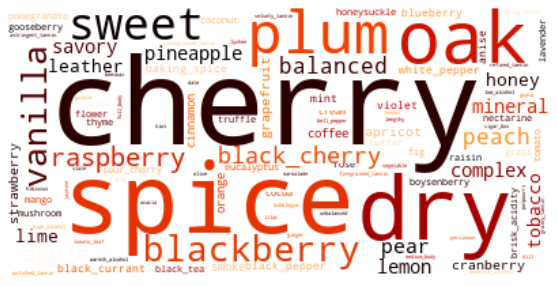

In [57]:
# Format to plot word cloud
full_list = [string for word in wine_grape['stand_reviews'] for string in word]
text_to_word_cloud = ' '.join(full_list)

# Plot word cloud
wordcloud = WordCloud(background_color="white", 
                      max_words=200,
                      collocations = False,
                      colormap='gist_heat')
wordcloud.generate(text_to_word_cloud)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, 
           interpolation='bilinear')
plt.axis("off")
plt.show()

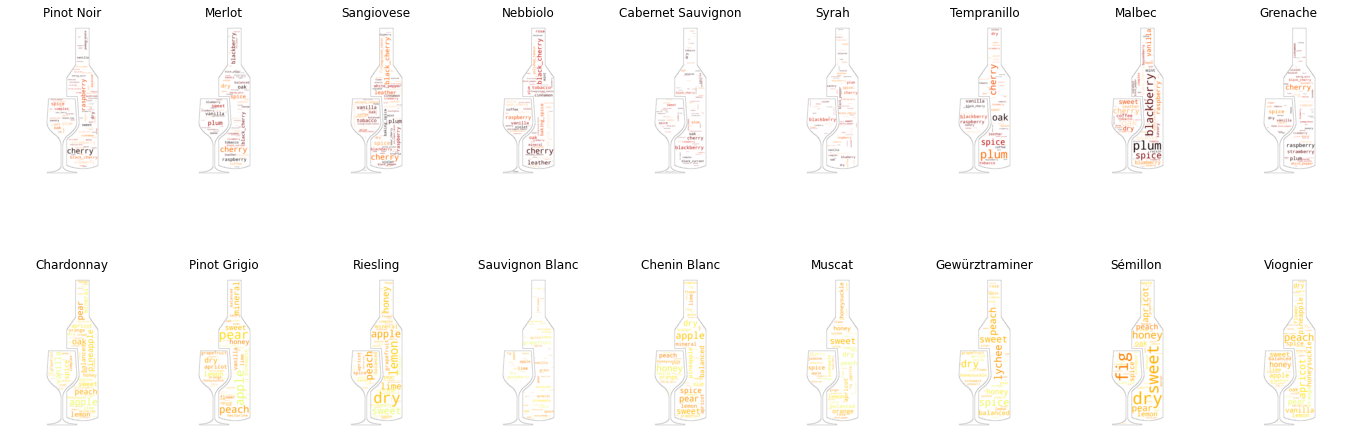

In [64]:
# Create wordcloud by wine variety
from PIL import Image
# Import an image to build a mask
wine_mask = np.array(Image.open('gdrive/My Drive/wine_mask.jpeg'))

# Format wine_mask to match wordclouds format (0 should be 255):
wine_mask_form = np.where(wine_mask>0, 255, wine_mask)

# Plot wordclouds    
plt.figure(figsize=(19,8))
for i, wine in enumerate(red_grape + white_grape):
    wine_ls = [string for word in wine_grape[wine_grape['variety']==wine].stand_reviews for string in word]
    wine_to_plot = ' '.join(wine_ls)
    
    # Select color red or white wine
    if wine in red_grape:
        colm = 'gist_heat'
    else:
        colm = 'Wistia'
    
    # Wordcloud config
    wordcloud = WordCloud(background_color="white",
                          max_words=200,
                          collocations=False,
                          colormap=colm,
                          mask=wine_mask_form,
                          contour_color='black',
                          contour_width=0.015)
    
    # Generate wordcloud
    wordcloud.generate(wine_to_plot)    
    plt.subplot(2,9,i+1)
    plt.imshow(wordcloud, 
               interpolation='bilinear')
    plt.axis("off")
    plt.title(wine, fontsize=12)

#plt.show()
plt.tight_layout()
#plt.savefig('/images/wordclouds_wine.pdf', dpi=300)  

In [67]:
# Filter wines by number of standardized descriptors
#Ideally we will still have a decent sized set of those with descriptions
wine_var_filt = wine_grape.copy()
print(f'reviews before filtering empty descriptions: {wine_var_filt.shape[0]}')

#reviews with at least one descriptor
rev_1 = wine_var_filt[wine_var_filt['stand_reviews'].apply(lambda x: len(x) > 0)].shape[0]
print(f'reviews with at least one descriptor: {rev_1}')
# reviews with atleast 3 descriptors
rev_3 = wine_var_filt[wine_var_filt['stand_reviews'].apply(lambda x: len(x) > 3)].shape[0]
print(f'reviews with at least 3 descriptors: {rev_3}')

# Filter wines with at least 5 descriptors
wine_var_filt = wine_var_filt[wine_var_filt['stand_reviews'].apply(lambda x: len(x) >= 5)]
print(f'Number of reviews with at least 5 standardized descriptors: {wine_var_filt.shape[0]}')

reviews before filtering empty descriptions: 66439
reviews with at least one descriptor: 59090
reviews with at least 3 descriptors: 13580
Number of reviews with at least 5 standardized descriptors: 5495


**We will try this out with three and five descriptors. After applying some encoding to convert the label into numpy/binary**

In [115]:
# Create multilabel binarizer with filtered and standardized data for 5 descriptors
mlb = MultiLabelBinarizer()
mlb_encoded_results = mlb.fit_transform(wine_var_filt['stand_reviews'])
# Classes created in after multilabel encoding
mlb.classes_
# Converting np.array into pd.dataframe
wine_var_filt_mlb = pd.DataFrame(mlb_encoded_results, columns=mlb.classes_)
# Index df by wine name
wine_var_filt_mlb.index = wine_var_filt['title']
wine_var_filt_mlb.head(n=5)

,acacia,anise,apple,apricot,astringent_tannin,baking_spice,balanced,beeswax,bell_pepper,black_cherry,black_currant,black_pepper,black_tea,blackberry,blueberry,boysenberry,brisk_acidity,bubblegum,butter,cherry,cigar_box,cinnamon,closegrained_tannin,cocoa,coconut,coffee,complex,cranberry,cream,date,dill,dry,drying_tannin,elderflower,eucalyptus,fennel,fig,finegrained_tannin,flower,fruitcake,...,mushroom,nectarine,oak,olive,orange,peach,pear,peony,persimmon,petroleum,pineapple,plum,polished_tannin,pomegranate,potpourri,quince,raisin,raspberry,refined_tannin,rose,savory,slate,smoke,sour_cherry,sourdough,spice,strawberry,sweet,thyme,tobacco,tomato,tomato_leaf,truffle,unbalanced,vanilla,vegetable,velvety_tannin,violet,warmth_alcohol,white_pepper
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Vincent Vineyards 2012 Family Reserve Cabernet Sauvignon (Santa Ynez Valley),0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Albatross Ridge 2012 Estate Reserve Pinot Noir (Carmel Valley),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
Big Basin 2013 Syrah (Santa Cruz Mountains),0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Castello di Gabbiano 2012 Bellezza Gran Selezione (Chianti Classico),0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
Claiborne & Churchill 2014 Claiborne Vineyard Riesling (Edna Valley),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [112]:
# Baseline reviews:
# Create reviews without standardization step to work as a baseline

# Extract tokens from normalized descriptions
terms_dict = {}
for rev_list in wine_grape['norm_description']:
    for item in rev_list:
        if item not in terms_dict:
            terms_dict[item] = 1
        else:
            terms_dict[item] += 1

# Get 600 most common descriptors
terms_dict_counter = Counter(terms_dict)
desc_list = []
for k,v in terms_dict_counter.most_common(600):
    desc_list.append(k)
desc_df = pd.DataFrame(desc_list)    

# Map full reviews to the 600 descriptors
full_reviews = get_standardized_reviews(wine_grape['norm_description'], desc_df[0])

# Add full reviews to dataFrame
wine_grape['full_review'] = full_reviews
wine_grape.head()

# Exclude reviews that don't have at least one of the 600 descriptors
wine_df_var_filt_full = wine_grape.copy()
print(f'Number of reviews before filtering empty descriptions: {wine_df_var_filt_full.shape[0]}')
wine_df_var_filt_full = wine_df_var_filt_full[wine_df_var_filt_full['full_review'].apply(lambda x: len(x) > 0)]
print(f'Number of reviews after filtering empty descriptions: {wine_df_var_filt_full.shape[0]}')

# Create multilabel binarizer with all normalized and filtered reviwes (as a baseline)
mlb_full = MultiLabelBinarizer()
mlb_full_encoded_results = mlb_full.fit_transform(wine_df_var_filt_full['full_review'])
# Classes created in after multilabel encoding
#mlb_full.classes_

# Converting np.array into pd.dataframe
wine_df_var_filt_full_mlb = pd.DataFrame(mlb_full_encoded_results, 
                                         columns=mlb_full.classes_)
# Index df by wine name
wine_df_var_filt_full_mlb.index = wine_df_var_filt_full['title']
wine_df_var_filt_full_mlb.head(n=10)

# Add price and rating to data frame to filter later
wine_df_var_filt_full_mlb['price'] = wine_df_var_filt_full['price'].values
wine_df_var_filt_full_mlb['rating'] = wine_df_var_filt_full['points'].values
wine_df_var_filt_full_mlb.head(n=10)

Number of reviews before filtering empty descriptions: 66439
Number of reviews after filtering empty descriptions: 66434


,100,100_varietal,2015,2016,2017,2018,2019,2020,2022,accent,accented,acid,acidic,acidity,across,add,aftertaste,age,aged,aging,alcohol,almond,almost,along,alongside,already,also,although,ample,anise,another,appeal,appealing,appellation,apple,apple_pear,approachable,apricot,aromatic,around,...,valley,vanilla,varietal,variety,velvety,vibrant,vine,vineyard,vintage,violet,wa,want,warm,wave,way,weight,well,whiff,white,white_flower,white_peach,white_pepper,wild,wild_berry,winemaker,winery,without,wood,wood_aging,woody,would,wrapped,year,yellow,yet,young,youthful,zest,zesty,rating
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
St. Julian 2013 Reserve Late Harvest Riesling (Lake Michigan Shore),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,87
Sweet Cheeks 2012 Vintner's Reserve Wild Child Block Pinot Noir (Willamette Valley),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,87
Trimbach 2012 Gewurztraminer (Alsace),0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,87
Heinz Eifel 2013 Shine Gewürztraminer (Rheinhessen),0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,87
Kirkland Signature 2011 Mountain Cuvée Cabernet Sauvignon (Napa Valley),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,87
Leon Beyer 2012 Gewurztraminer (Alsace),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,87
Louis M. Martini 2012 Cabernet Sauvignon (Alexander Valley),0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,87
Mirassou 2012 Chardonnay (Central Coast),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,87
Richard Böcking 2013 Devon Riesling (Mosel),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,87


In [80]:
import copy
wine_mod = copy.deepcopy(wine_df_var_filt_full_mlb)

In [116]:
# Add price and rating to data frame to filter later
wine_var_filt_mlb['price'] = wine_var_filt['price'].values
wine_var_filt_mlb['rating'] = wine_var_filt['points'].values

In [117]:
wine_var_filt_mlb.head(5)

,acacia,anise,apple,apricot,astringent_tannin,baking_spice,balanced,beeswax,bell_pepper,black_cherry,black_currant,black_pepper,black_tea,blackberry,blueberry,boysenberry,brisk_acidity,bubblegum,butter,cherry,cigar_box,cinnamon,closegrained_tannin,cocoa,coconut,coffee,complex,cranberry,cream,date,dill,dry,drying_tannin,elderflower,eucalyptus,fennel,fig,finegrained_tannin,flower,fruitcake,...,oak,olive,orange,peach,pear,peony,persimmon,petroleum,pineapple,plum,polished_tannin,pomegranate,potpourri,quince,raisin,raspberry,refined_tannin,rose,savory,slate,smoke,sour_cherry,sourdough,spice,strawberry,sweet,thyme,tobacco,tomato,tomato_leaf,truffle,unbalanced,vanilla,vegetable,velvety_tannin,violet,warmth_alcohol,white_pepper,price,rating
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Vincent Vineyards 2012 Family Reserve Cabernet Sauvignon (Santa Ynez Valley),0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68.0,91
Albatross Ridge 2012 Estate Reserve Pinot Noir (Carmel Valley),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,55.0,91
Big Basin 2013 Syrah (Santa Cruz Mountains),0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.0,91
Castello di Gabbiano 2012 Bellezza Gran Selezione (Chianti Classico),0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,38.0,91
Claiborne & Churchill 2014 Claiborne Vineyard Riesling (Edna Valley),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28.0,91


In [102]:
# Instantiate knn model to cluster similarities
knn = NearestNeighbors(n_neighbors=5,
                       algorithm='brute', 
                       metric='cosine')

In [118]:
# Get wine recommendations
def get_recommendations(input_df=wine_var_filt_mlb, 
                        wine_idx=None, 
                        max_price=1000000, 
                        min_rate=80):
    try: 
    # Filter data based on max price and min rating
        df_mlb_filt = input_df.loc[(input_df['price'] < max_price) & 
                                   (input_df['rating'] >= min_rate)]
    
        if df_mlb_filt.shape[0] > 1:
    
            # Select a wine randomly if none is provided
            if wine_idx is None:
                query_index = np.random.choice(df_mlb_filt.shape[0])
            
            # Use input wine name to get index
            else:
                wine_name = df_mlb_filt.index == wine_idx
                query_index = [int(idx) for idx in wine_name.nonzero()][0]
    
            # Fit knn model
            model_knn = knn.fit(df_mlb_filt.iloc[:,:-2])
    
            # Get distances and indexes from the top 5 neighbors
            distance, index_neigh = model_knn.kneighbors(df_mlb_filt.iloc[query_index,:-2].values.reshape(1,-1), 
                                                         n_neighbors=6)
    
            # Return top 5 recommendations
            for i in range(0, len(distance.flatten())):
                if  i == 0:
                    print(f'Top 5 recommendations for: \n{df_mlb_filt.index[query_index]} | Price: ${df_mlb_filt.price[query_index]} | Rating: {df_mlb_filt.rating[query_index]} \n')
                else:
                    print(f'#{i}: {df_mlb_filt.index[index_neigh.flatten()[i]]} | (Distance: {round(distance.flatten()[i], 4)}) \nPrice: ${df_mlb_filt.price[index_neigh.flatten()[i]]} | Rating: {df_mlb_filt.rating[index_neigh.flatten()[i]]}\n')
    except:
        raise Exception('0 recommendations available. \nTry to increase maximum price and/or decrease minimum rate.')

In [119]:
get_recommendations(input_df=wine_var_filt_mlb,
                    wine_idx='Cederberg 2010 Sauvignon Blanc (Cederberg)')

Top 5 recommendations for: 
Cederberg 2010 Sauvignon Blanc (Cederberg) | Price: $22.0 | Rating: 88 

#1: Spier 2016 Vintage Selection Sauvignon Blanc (Coastal Region) | (Distance: 0.2) 
Price: $17.0 | Rating: 90

#2: Robert Weil 2015 Kiedrich Gräfenberg Auslese Riesling (Rheingau) | (Distance: 0.2697) 
Price: $182.0 | Rating: 95

#3: Joh. Jos. Prüm 2011 Graacher Himmelreich Auslese GoldKap Riesling (Mosel) | (Distance: 0.4) 
Price: $107.0 | Rating: 95

#4: Palo Alto 2009 Reserva Sauvignon Blanc (Maule Valley) | (Distance: 0.4) 
Price: $12.0 | Rating: 86

#5: Mulderbosch 2011 Chenin Blanc (Western Cape) | (Distance: 0.4) 
Price: $15.0 | Rating: 88



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  "X does not have valid feature names, but"


In [120]:
get_recommendations(input_df=wine_var_filt_mlb,
                    wine_idx='Migration 2014 Pinot Noir (Russian River Valley)')

Top 5 recommendations for: 
Migration 2014 Pinot Noir (Russian River Valley) | Price: $38.0 | Rating: 91 

#1: Matetic 2009 Syrah (San Antonio) | (Distance: 0.2697) 
Price: $86.0 | Rating: 91

#2: Coeur d'Alene 2013 Merlot (Washington) | (Distance: 0.2697) 
Price: $30.0 | Rating: 88

#3: Bunnell 2011 Grenache (Columbia Valley (WA)) | (Distance: 0.2697) 
Price: $36.0 | Rating: 90

#4: Almquist 2009 Milbrant Vineyard Syrah (Wahluke Slope) | (Distance: 0.2697) 
Price: $28.0 | Rating: 88

#5: Kontos 2012 Merlot (Walla Walla Valley (WA)) | (Distance: 0.2697) 
Price: $26.0 | Rating: 91



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  "X does not have valid feature names, but"


**We are getting there. Time to iterate over the model**

In [121]:
# Re-weight descriptors using TF-IDF

# function to format reviews for TF-IDF
def get_formated_reviews_tfidf(input_std_reviews):
    form_reviews = []
    for review in input_std_reviews:
        form_review = ' '.join(review)
        form_reviews.append(form_review)
    return form_reviews

# Format reviews
tfidf_r = get_formated_reviews_tfidf(wine_var_filt['stand_reviews'])

# Instantiate TF-IDF model
vectorizer = TfidfVectorizer()
# Fit model
vectorizer_fit = vectorizer.fit(tfidf_r)

In [122]:
# Build a data frame with features weighted by TF-IDF
dict_tfidf = dict(zip(vectorizer_fit.get_feature_names(), vectorizer_fit.idf_))
wine_filt_tfidf = wine_var_filt_mlb.copy()

# Map ones to tf-idf weights
for col in wine_filt_tfidf.iloc[:, :-2]:
    wine_filt_tfidf.loc[wine_filt_tfidf[col] == 1, col] = dict_tfidf[col]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [124]:
# Compare it with recommendations from multi-label binarized data

get_recommendations(input_df=wine_filt_tfidf,
                    wine_idx='Migration 2014 Pinot Noir (Russian River Valley)')

Top 5 recommendations for: 
Migration 2014 Pinot Noir (Russian River Valley) | Price: $38.0 | Rating: 91 

#1: Kontos 2012 Merlot (Walla Walla Valley (WA)) | (Distance: 0.2573) 
Price: $26.0 | Rating: 91

#2: Almquist 2009 Milbrant Vineyard Syrah (Wahluke Slope) | (Distance: 0.2573) 
Price: $28.0 | Rating: 88

#3: Bunnell 2011 Grenache (Columbia Valley (WA)) | (Distance: 0.2612) 
Price: $36.0 | Rating: 90

#4: Cottonwood Winery of Oregon 2008 Raya Jade Syrah (Yakima Valley) | (Distance: 0.2688) 
Price: $19.0 | Rating: 88

#5: Matetic 2009 Syrah (San Antonio) | (Distance: 0.2873) 
Price: $86.0 | Rating: 91



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  "X does not have valid feature names, but"


**This gives us a pretty good understanding of the dataset and what will be important for our next model. We will be using Bert and transformer. Giving higher weight to price a variety. It will be more streamlined for app deployment.**